In [1]:
import numpy as np
import pandas as pd
import multiprocessing as mp
from inspect import signature
from matplotlib import pyplot as plt
from dacbench.logger import Logger, log2dataframe, load_logs
import seaborn as sns
import glob
from plotting import _plot_performance_over_time, plot_performance_over_time, plot_final_performance_comparison, plot_improvement_probability, plot_configuration_footprint, plot_hp_importance, plot_deepcave
#from plotting import plot_performance_over_time, plot_final_performance_comparison, plot_improvement_probability, plot_configuration_footprint, plot_hp_importance, plot_deepcave

/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/dacbench/envs/__init__.py:35: UserWarning: CMA-ES Benchmark not installed. If you want to use this benchmark, please follow the installation guide.
  warnings.warn(  # noqa: B028
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/dacbench/benchmarks/__init__.py:26: UserWarning: CMA-ES Benchmark not installed. If you want to use this benchmark, please follow the installation guide.
  warnings.warn(  # noqa: B028


DACBench Gym registration failed - make sure you have all dependencies installed and their instance sets in the right path!


In [2]:
def toDataFrame(glob_path, col_name, col_index, method=None, dataset=None):
    d =  [log2dataframe(load_logs(path)) for path in glob.glob(glob_path)]
    
    df = pd.DataFrame([s[col_name][col_index] for s in d]).transpose()
    df['epoch'] = df.index + 1
    df = df.melt(id_vars=['epoch'])
    df.rename(columns={'variable': 'seed'}, inplace=True)
    
    if method:
        df['method'] = method

    if dataset:
        df['dataset'] = dataset

    return df

def toChunkedDataFrame(glob_path, col_name, col_index, chunk_size, method=None, dataset=None):
    d =  [log2dataframe(load_logs(path)) for path in glob.glob(glob_path)]

    df = pd.DataFrame([s[col_name][col_index] for s in d]).transpose()

    result_df = pd.DataFrame()
    for col in df.columns:
        reshaped_data = df[col].values.reshape(-1, chunk_size)
        result_df[col] = reshaped_data.mean(axis=1)

    result_df.reset_index()

    result_df['epoch'] = result_df.index + 1
    result_df = result_df.melt(id_vars=['epoch'])

    if method:
        result_df['method'] = method

    if dataset:
        result_df['dataset'] = dataset

    return result_df


sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style('whitegrid')
palette = sns.color_palette("colorblind")
palette = sns.color_palette([palette[0], palette[4], palette[2], palette[5], palette[8]])
sns.set_palette(palette)
sns.set_context("notebook", font_scale=1.15)

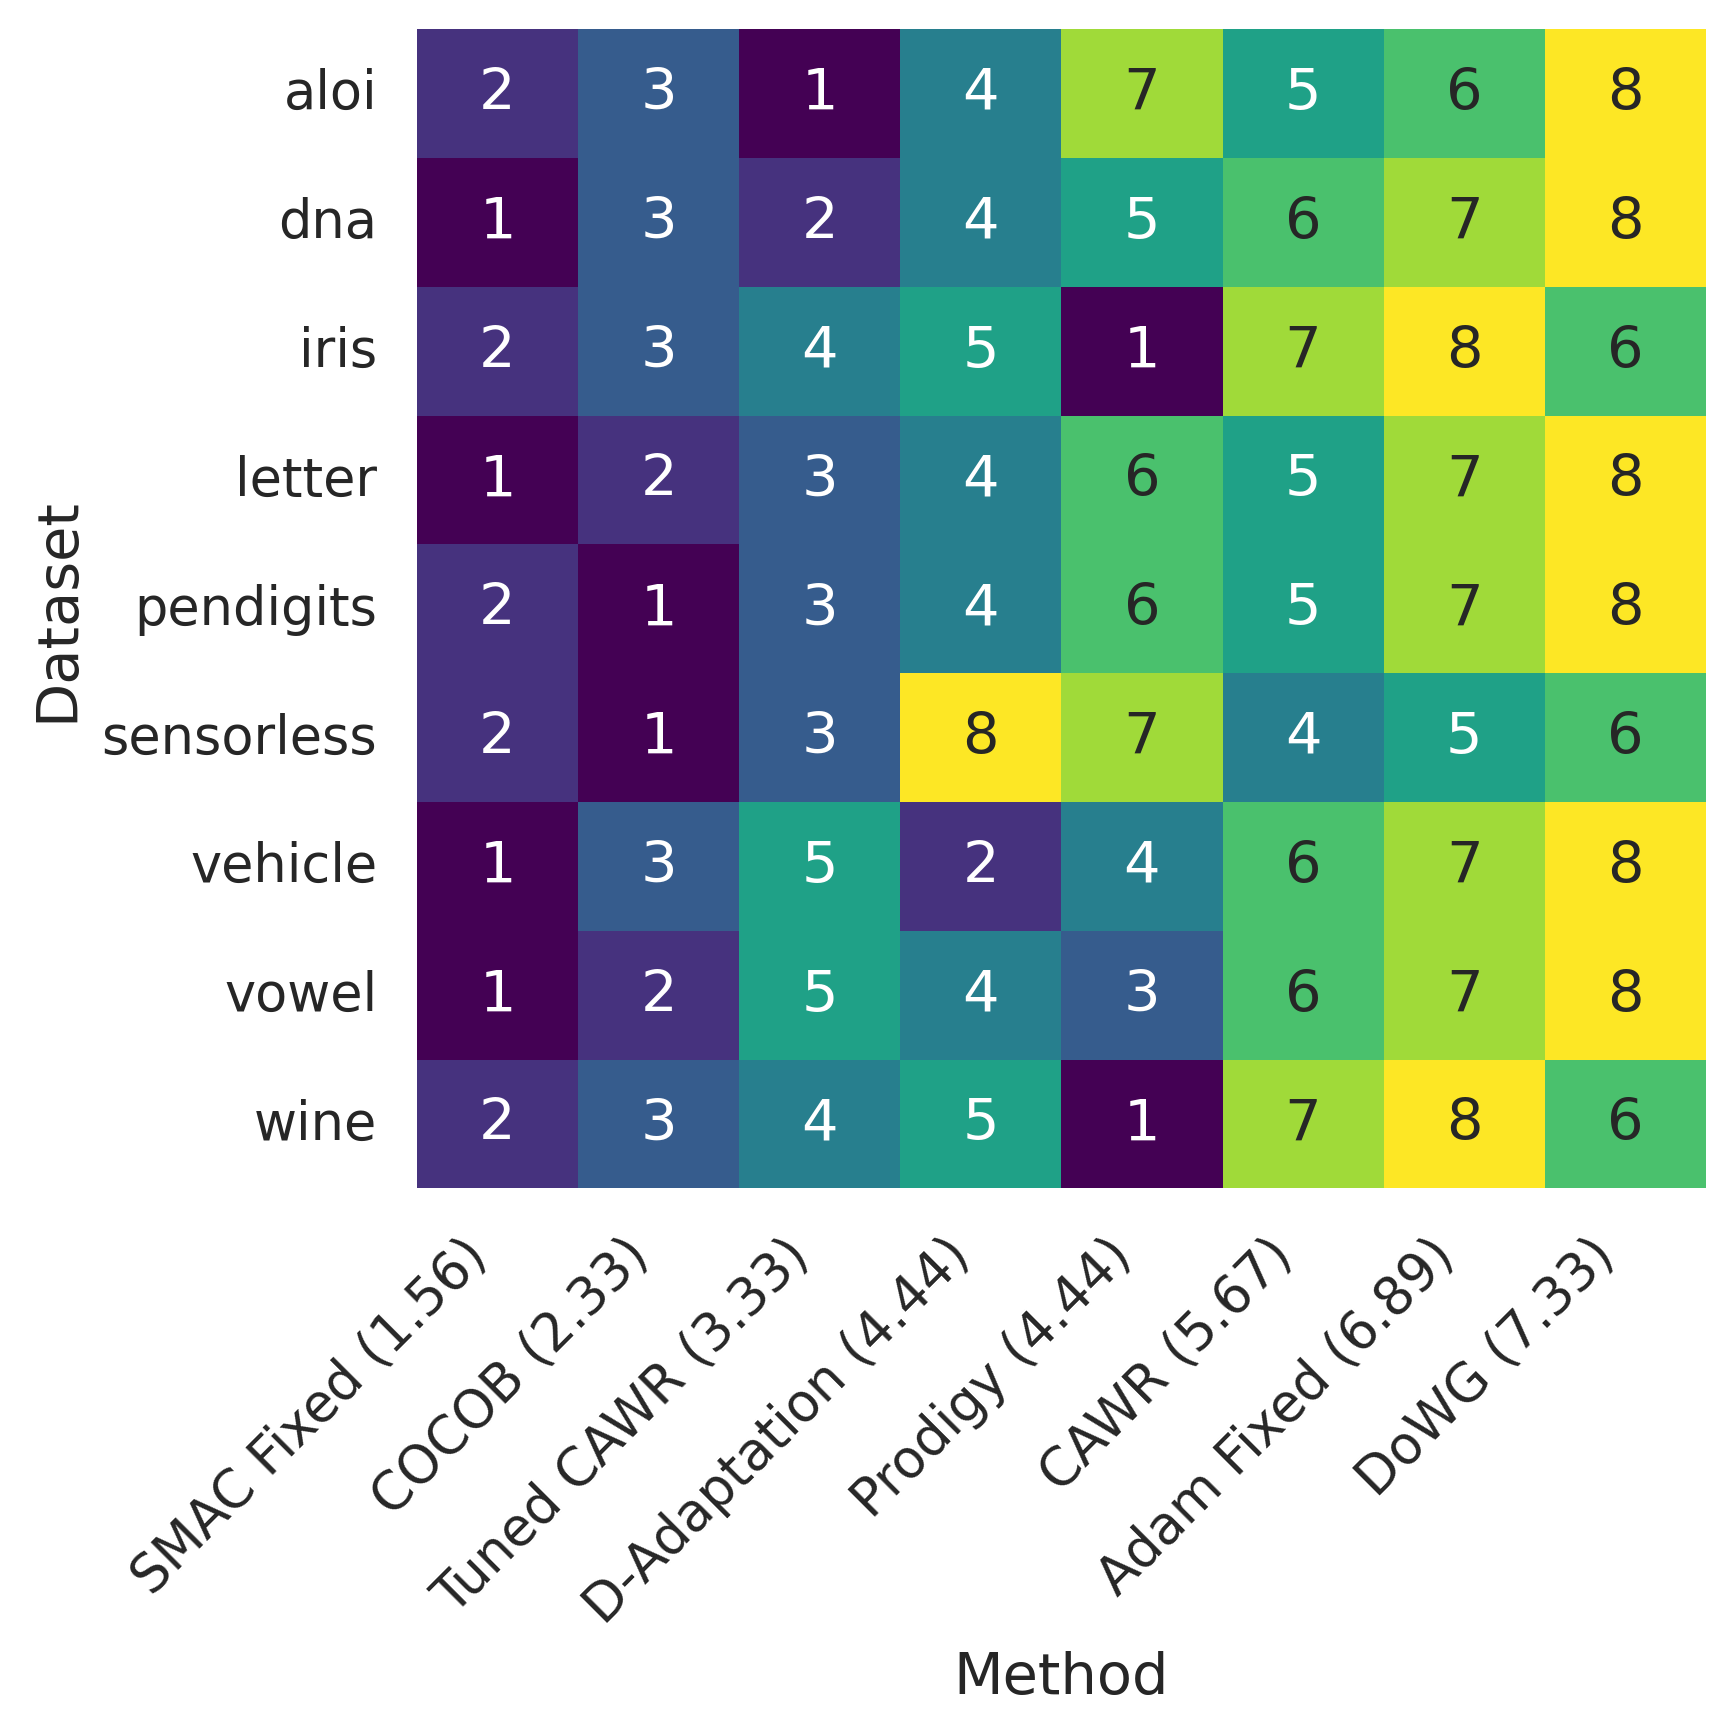

In [3]:
datasets_and_batches = {
    'aloi': 1688,
    'dna': 32,
    'iris': 3,
    'letter': 235,
    'pendigits': 118,
    'sensorless': 915,
    'vehicle': 14,
    'vowel': 9,
    'wine': 3
}

cawr_tl = pd.concat([toChunkedDataFrame('../results_cluster/results/CAWR_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, datasets_and_batches[dataset], method='CAWR', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
tuned_cawr_tl = pd.concat([toChunkedDataFrame('../results_cluster/results/tuned_cawr_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, datasets_and_batches[dataset], method='Tuned CAWR', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
smacfixed_tl = pd.concat([toDataFrame('../results_cluster/results/tuned_smacfixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='SMAC Fixed', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
adam_fixed_tl = pd.concat([toDataFrame('../results_cluster/results/Adam_fixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='Adam Fixed', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
# cocob_tl = pd.concat([toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='COCOB', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)

# 'seed', 'epoch', 'method', 'training_loss' 'dataset'
df_others = pd.concat([adam_fixed_tl, cawr_tl, smacfixed_tl, tuned_cawr_tl], ignore_index=True)

cocob_tl = pd.concat([toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='COCOB', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
dadaptation_tl = pd.concat([toDataFrame('../results_cluster/results/dadaptation_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='D-Adaptation', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
prodigy_tl = pd.concat([toDataFrame('../results_cluster/results/prodigy_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='Prodigy', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
# adam_fixed_tl = pd.concat([toDataFrame('../results_cluster/results/Adam_fixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='Adam Fixed', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
dowg_tl = pd.concat([toDataFrame('../results_cluster/results/DoWG_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='DoWG', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
#

# 'seed', 'epoch', 'method', 'training_loss' 'dataset'

df_pfo = pd.concat([cocob_tl, dadaptation_tl, dowg_tl, prodigy_tl], ignore_index=True)

df_others["group"] = "others"
df_pfo["group"] = "parameterfree"

df = pd.concat([df_others, df_pfo], ignore_index=True)

# 1. Aggregate over seeds per epoch
df = df.groupby(["dataset", "method", "group", "epoch"], as_index=False)["value"].mean()

# 2. Select the final epoch for each dataset-method-group combination
df = df.loc[
    df.groupby(["dataset", "method", "group"])["epoch"].idxmax()
].reset_index(drop=True)

# 3. Rank the methods for each dataset based on the final training loss (lower is better)
df["rank"] = df.groupby("dataset")["value"].rank(method="min", ascending=True)

# 4. Create a pivot table: datasets as rows and methods as columns (cells contain the rank)
pivot_df = df.pivot(index="dataset", columns="method", values="rank")

# 5. Compute the average rank for each method over all datasets
avg_ranks = df.groupby("method")["rank"].mean()

# 6. Sort the methods by average rank (lowest rank to highest rank)
sorted_methods = avg_ranks.sort_values().index.tolist()

# 7. Reorder the pivot table columns based on the sorted method order
pivot_df = pivot_df[sorted_methods]

# 8. Update the column labels to include the average rank
new_columns = [f"{method} ({avg_ranks[method]:.2f})" for method in pivot_df.columns]
pivot_df.columns = new_columns

# 9. Plot the heatmap with the sorted columns
plt.figure(figsize=(6, 6))
ax = sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="viridis", cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel("Method")
plt.ylabel("Dataset")
plt.tight_layout()
plt.show()

# plot_performance_over_time(
#         data=df,
#         x="epoch",
#         y="rank",
#         xlabel="Epochs",
#         ylabel="Rank",
#         aggregation="rank",
#         errorbar="se",
#         hue="method",
#         col="dataset",
#         # row="dataset",
#         # col_wrap=3,
#         sharey=False,
#         aspect=1.5
#     )

      dataset   method  epoch     value  best_value
0        aloi    COCOB    100  0.294290    0.294290
1         dna    COCOB    100  0.971875    0.971875
2        iris    COCOB    100  0.801089    0.801089
3      letter    COCOB    100  0.499650    0.499650
4   pendigits    COCOB    100  0.888467    0.888467
5  sensorless    COCOB    100  0.292618    0.292618
6     vehicle    COCOB    100  0.685332    0.685332
7       vowel  Prodigy    100  0.493056    0.493056
8        wine  Prodigy    100  0.989375    0.989375
       epoch seed     value   method  dataset
16000      1    0  2.412497  Prodigy    vowel
16001      2    0  2.396588  Prodigy    vowel
16002      3    0  2.382281  Prodigy    vowel
16003      4    0  2.155517  Prodigy    vowel
16004      5    0  1.976976  Prodigy    vowel
...      ...  ...       ...      ...      ...
24995     96    9  1.147646    COCOB  vehicle
24996     97    9  1.100552    COCOB  vehicle
24997     98    9  1.005367    COCOB  vehicle
24998     99    9  1

/tmp/ipykernel_347765/3563060476.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['method'] = 'Best HP-Free'
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages

<Figure size 1200x1200 with 0 Axes>

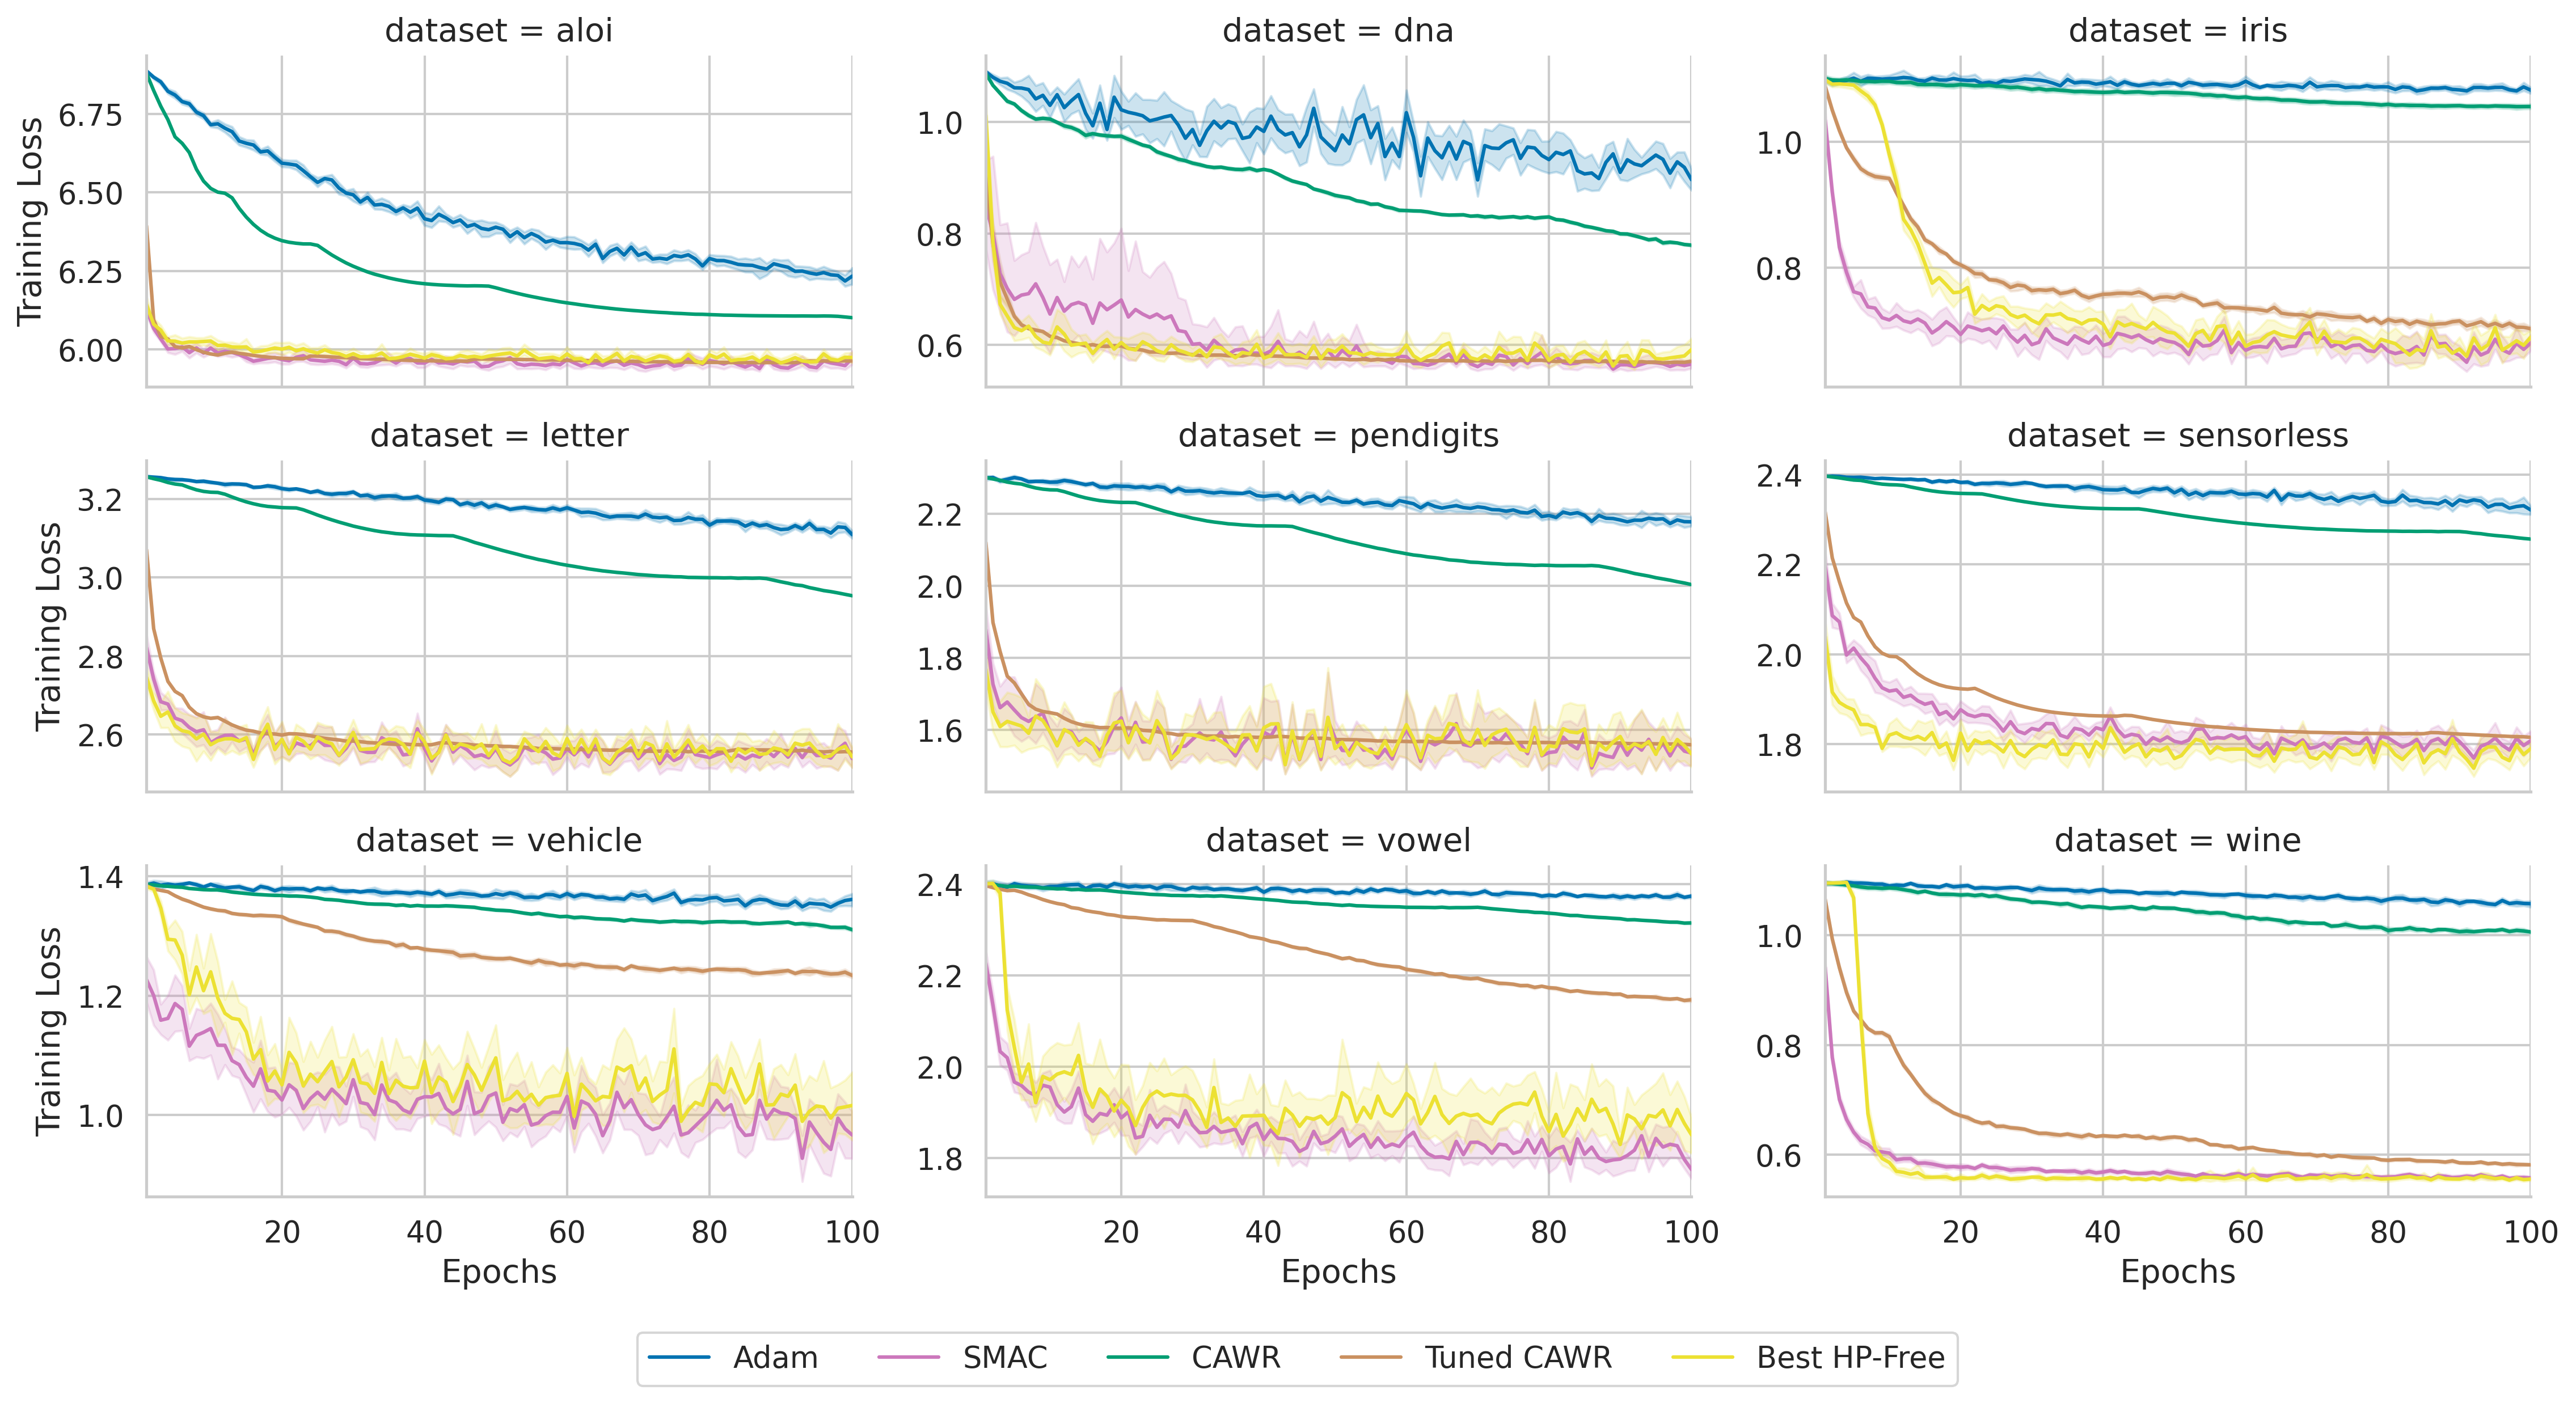

In [4]:
datasets_and_batches = {
    'aloi': 1688,
    'dna': 32,
    'iris': 3,
    'letter': 235,
    'pendigits': 118,
    'sensorless': 915,
    'vehicle': 14,
    'vowel': 9,
    'wine': 3
}

cawr_tl = pd.concat([toChunkedDataFrame('../results_cluster/results/CAWR_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, datasets_and_batches[dataset], method='CAWR', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
tuned_cawr_tl = pd.concat([toChunkedDataFrame('../results_cluster/results/tuned_cawr_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, datasets_and_batches[dataset], method='Tuned CAWR', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
smacfixed_tl = pd.concat([toDataFrame('../results_cluster/results/tuned_smacfixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='SMAC', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
adam_fixed_tl = pd.concat([toDataFrame('../results_cluster/results/Adam_fixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='Adam', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
# cocob_tl = pd.concat([toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='COCOB', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)

cocob_tl = pd.concat([toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='COCOB', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
dadaptation_tl = pd.concat([toDataFrame('../results_cluster/results/dadaptation_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='D-Adaptation', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
prodigy_tl = pd.concat([toDataFrame('../results_cluster/results/prodigy_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='Prodigy', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
dowg_tl = pd.concat([toDataFrame('../results_cluster/results/DoWG_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='DoWG', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)

df_pfo = pd.concat([dadaptation_tl, prodigy_tl, cocob_tl, dowg_tl], ignore_index=True)

df = df_pfo.groupby(["dataset", "method", "epoch"], as_index=False)["value"].mean()

# 2. Select the final epoch for each dataset-method-group combination
df = df.loc[
    df.groupby(["dataset", "method"])["epoch"].idxmax()
].reset_index(drop=True)

# 3. For each dataset, compute the best (highest) accuracy,
#    then compute the difference for each method as (best_value - current_value).
df["best_value"] = df.groupby("dataset")["value"].transform("max")

best_methods_df = df[df['value'] == df['best_value']].copy()
# In case there are multiple rows per dataset, group and take the first one.
best_methods_df = best_methods_df.groupby('dataset').first().reset_index()

# Option 2: Alternatively, you can simply use idxmax on the 'value' column:
best_methods_df = df.loc[df.groupby('dataset')['value'].idxmax()].reset_index(drop=True)
print(best_methods_df)
best_method_dict = best_methods_df.set_index('dataset')['method'].to_dict()

cocob_tl = pd.concat([toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='COCOB', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
dadaptation_tl = pd.concat([toDataFrame('../results_cluster/results/dadaptation_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='D-Adaptation', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
prodigy_tl = pd.concat([toDataFrame('../results_cluster/results/prodigy_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='Prodigy', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
dowg_tl = pd.concat([toDataFrame('../results_cluster/results/DoWG_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='DoWG', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)

df_pfo = pd.concat([dadaptation_tl, prodigy_tl, cocob_tl, dowg_tl], ignore_index=True)

# Now select all rows from df_pfo where the row's method matches the best method for that dataset
df_filtered = df_pfo[df_pfo['method'] == df_pfo['dataset'].map(best_method_dict)]
print(df_filtered)
df_filtered['method'] = 'Best HP-Free'
# 'seed', 'epoch', 'method', 'training_loss' 'dataset'
df = pd.concat([adam_fixed_tl, smacfixed_tl, cawr_tl, tuned_cawr_tl], ignore_index=True)
df = pd.concat([df, df_filtered])

g = _plot_performance_over_time(
        data=df,
        x="epoch",
        y="value",
        xlabel="Epochs",
        ylabel="Training Loss",
        aggregation="mean",
        hue="method",
        col="dataset",
        col_wrap=3,
        sharey=False,
        aspect=1.5,
        palette=palette
    )

# Remove the legends from each facet.
for ax in g.axes.flat:
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

# Now, get handles and labels from one of the facets.
handles, labels = g.axes.flat[0].get_legend_handles_labels()
g._legend.remove()
# Add a global legend to the entire figure below the plots.
g.fig.legend(handles, labels,
             loc="lower center",
             bbox_to_anchor=(0.5, 0.05),  # adjust as needed
             ncol=len(labels),             # one column per label
             title=None,
             frameon=True)

# Optionally, remove facet titles if you don't need them.
g.fig.suptitle("")

# Adjust layout to make space for the legend.
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

      dataset   method  epoch     value  best_value
0        aloi    COCOB    100  0.294290    0.294290
1         dna    COCOB    100  0.971875    0.971875
2        iris    COCOB    100  0.801089    0.801089
3      letter    COCOB    100  0.499650    0.499650
4   pendigits    COCOB    100  0.888467    0.888467
5  sensorless    COCOB    100  0.292618    0.292618
6     vehicle    COCOB    100  0.685332    0.685332
7       vowel  Prodigy    100  0.493056    0.493056
8        wine  Prodigy    100  0.989375    0.989375
       epoch seed     value   method  dataset
16000      1    0  0.078125  Prodigy    vowel
16001      2    0  0.125000  Prodigy    vowel
16002      3    0  0.187500  Prodigy    vowel
16003      4    0  0.281250  Prodigy    vowel
16004      5    0  0.265625  Prodigy    vowel
...      ...  ...       ...      ...      ...
24995     96    9  0.726562    COCOB  vehicle
24996     97    9  0.585938    COCOB  vehicle
24997     98    9  0.695950    COCOB  vehicle
24998     99    9  0

/tmp/ipykernel_347765/1323207032.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['method'] = 'Best HP-Free'
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages

<Figure size 1200x1200 with 0 Axes>

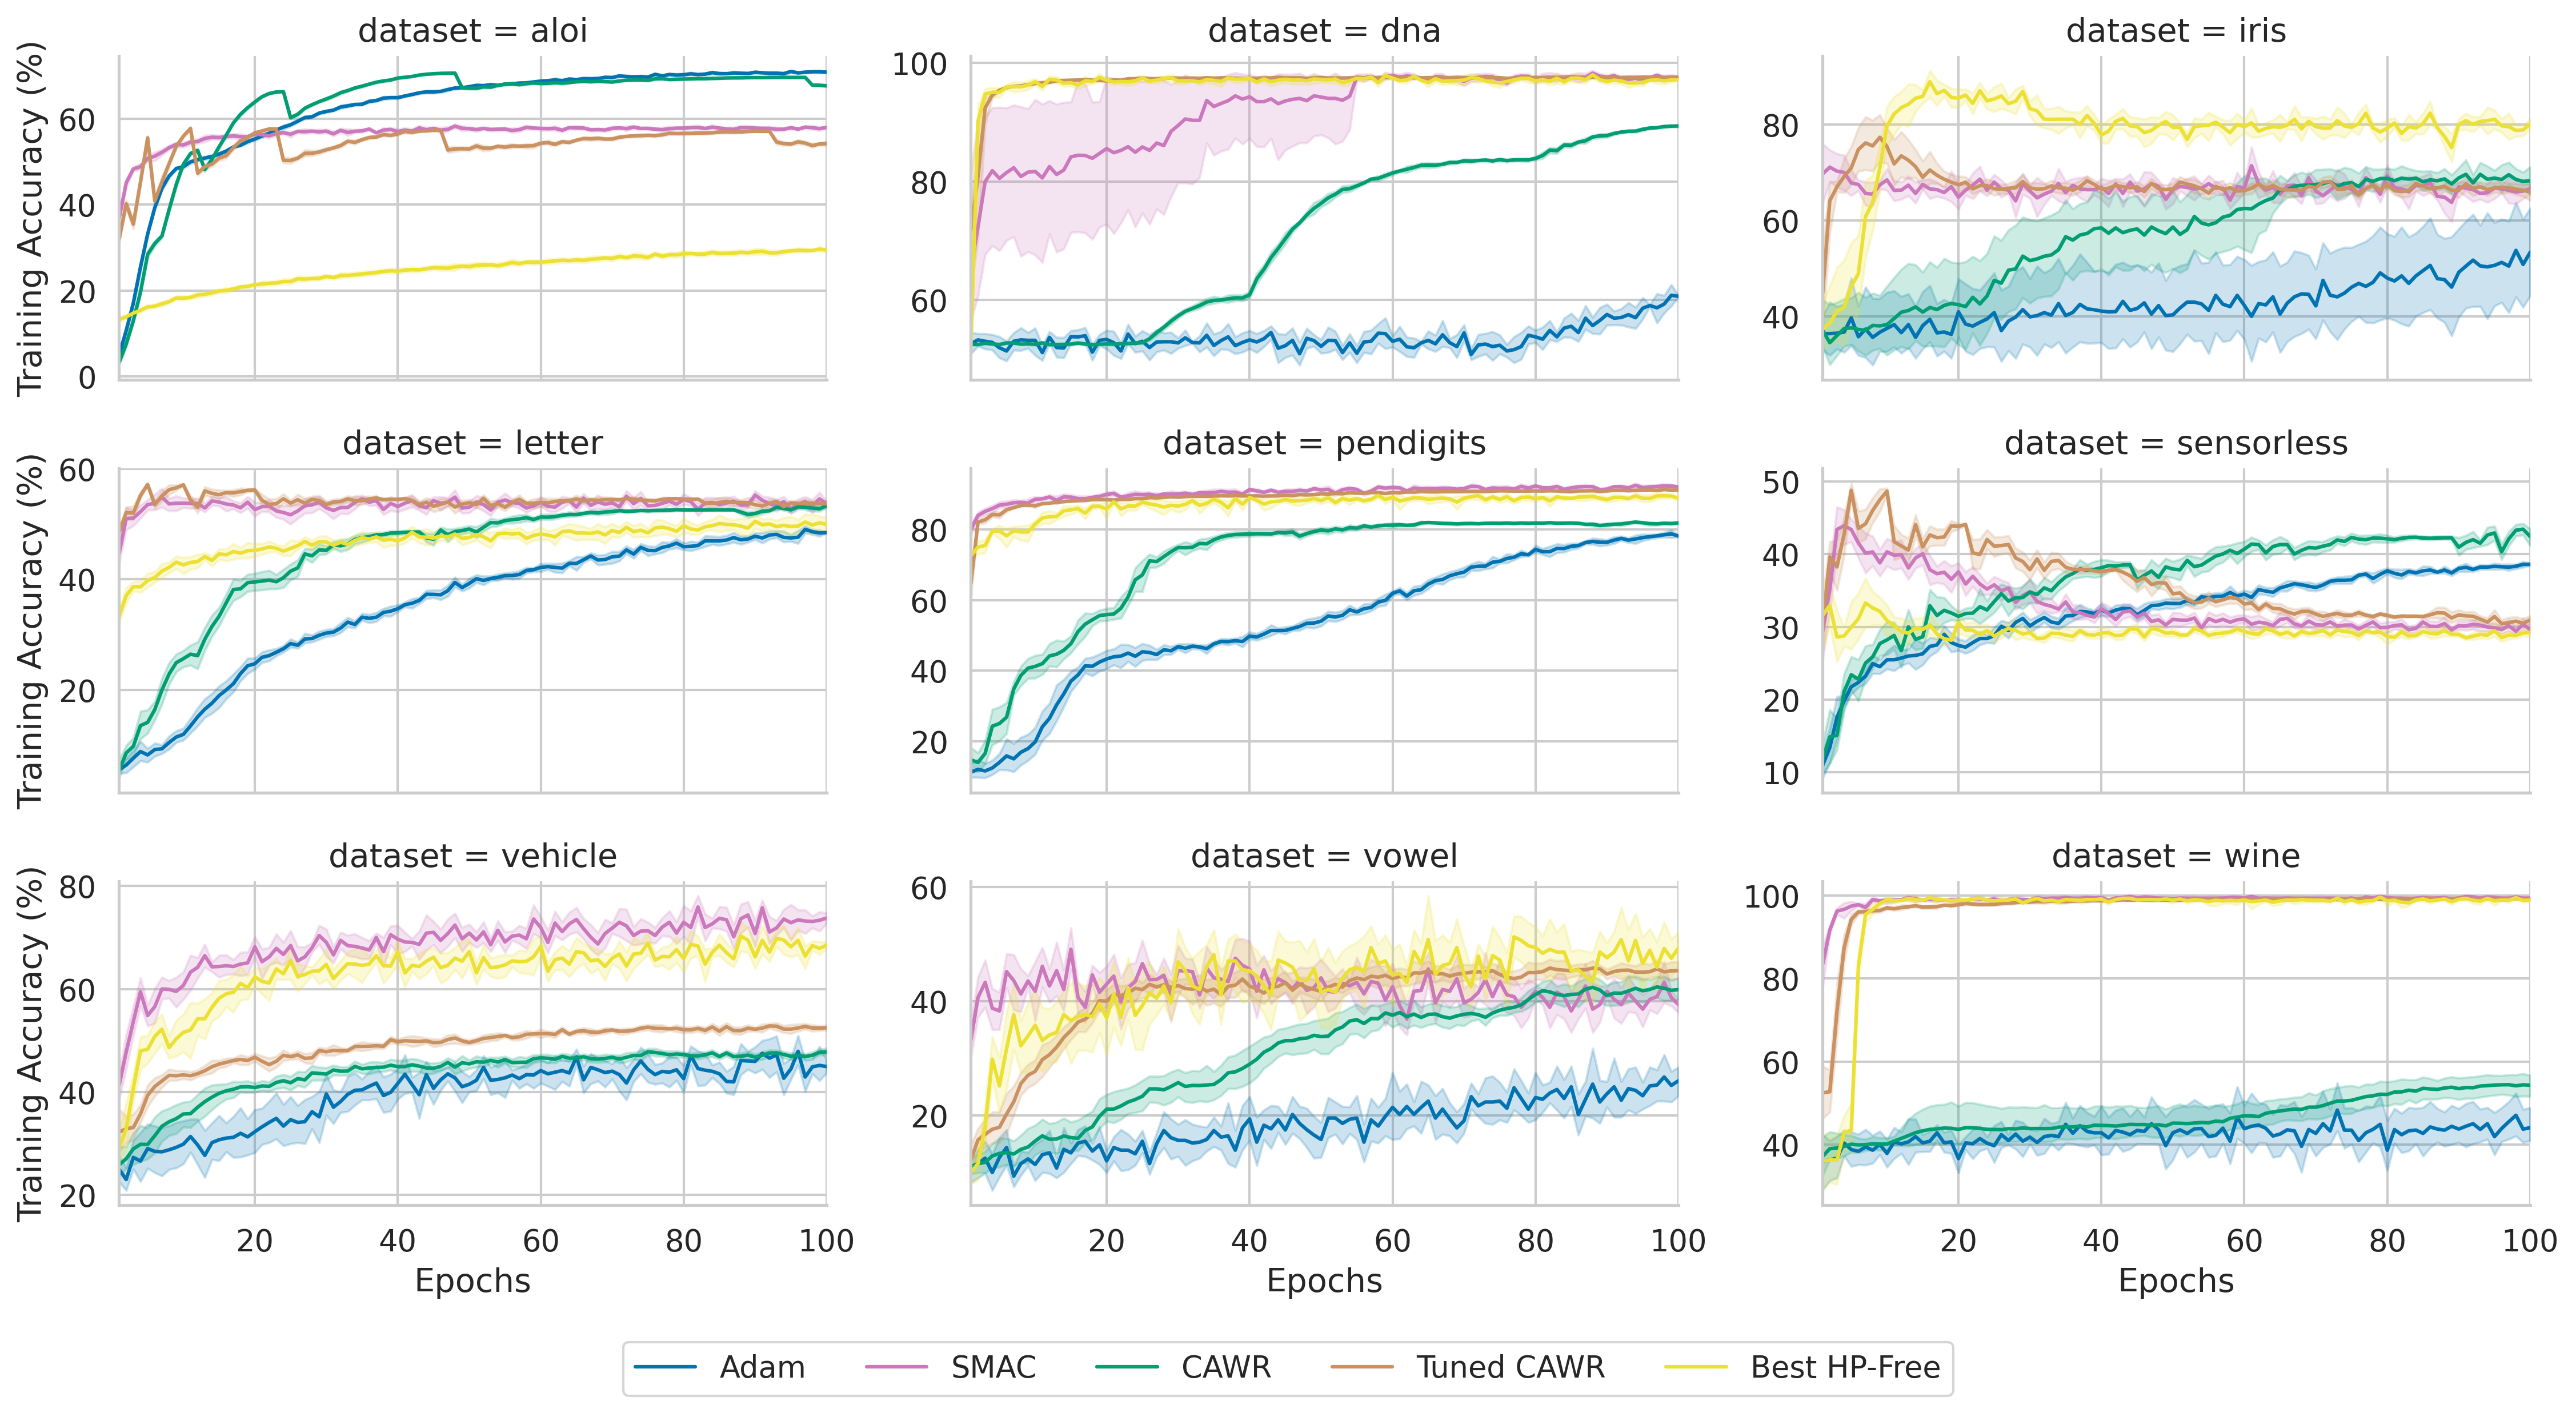

In [5]:
datasets_and_batches = {
    'aloi': 1688,
    'dna': 32,
    'iris': 3,
    'letter': 235,
    'pendigits': 118,
    'sensorless': 915,
    'vehicle': 14,
    'vowel': 9,
    'wine': 3
}

cawr_tl = pd.concat([toDataFrame('../results_cluster/results/CAWR_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='CAWR', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
tuned_cawr_tl = pd.concat([toDataFrame('../results_cluster/results/tuned_cawr_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='Tuned CAWR', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
smacfixed_tl = pd.concat([toDataFrame('../results_cluster/results/tuned_smacfixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='SMAC', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
adam_fixed_tl = pd.concat([toDataFrame('../results_cluster/results/Adam_fixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='Adam', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
# cocob_tl = pd.concat([toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='COCOB', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)

cocob_tl = pd.concat([toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='COCOB', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
dadaptation_tl = pd.concat([toDataFrame('../results_cluster/results/dadaptation_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='D-Adaptation', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
prodigy_tl = pd.concat([toDataFrame('../results_cluster/results/prodigy_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='Prodigy', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)
dowg_tl = pd.concat([toDataFrame('../results_cluster/results/DoWG_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='DoWG', dataset=dataset) for dataset in datasets_and_batches.keys()], ignore_index=True)

df_pfo = pd.concat([dadaptation_tl, prodigy_tl, cocob_tl, dowg_tl], ignore_index=True)

df = df_pfo.groupby(["dataset", "method", "epoch"], as_index=False)["value"].mean()

# 2. Select the final epoch for each dataset-method-group combination
df = df.loc[
    df.groupby(["dataset", "method"])["epoch"].idxmax()
].reset_index(drop=True)

# 3. For each dataset, compute the best (highest) accuracy,
#    then compute the difference for each method as (best_value - current_value).
df["best_value"] = df.groupby("dataset")["value"].transform("max")

best_methods_df = df[df['value'] == df['best_value']].copy()
# In case there are multiple rows per dataset, group and take the first one.
best_methods_df = best_methods_df.groupby('dataset').first().reset_index()

# Option 2: Alternatively, you can simply use idxmax on the 'value' column:
best_methods_df = df.loc[df.groupby('dataset')['value'].idxmax()].reset_index(drop=True)
print(best_methods_df)
best_method_dict = best_methods_df.set_index('dataset')['method'].to_dict()

# Now select all rows from df_pfo where the row's method matches the best method for that dataset
df_filtered = df_pfo[df_pfo['method'] == df_pfo['dataset'].map(best_method_dict)]
print(df_filtered)
df_filtered['method'] = 'Best HP-Free'

# 'seed', 'epoch', 'method', 'training_loss' 'dataset'
df = pd.concat([adam_fixed_tl, smacfixed_tl, cawr_tl, tuned_cawr_tl, df_filtered], ignore_index=True)
df['value'] = df['value'] * 100 # convert to percent

g = _plot_performance_over_time(
        data=df,
        x="epoch",
        y="value",
        xlabel="Epochs",
        ylabel="Training Accuracy (%)",
        aggregation="mean",
        hue="method",
        col="dataset",
        col_wrap=3,
        sharey=False,
        aspect=1.5,
        palette=palette
    )

# Remove the legends from each facet.
for ax in g.axes.flat:
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

# Now, get handles and labels from one of the facets.
handles, labels = g.axes.flat[0].get_legend_handles_labels()
g._legend.remove()
# Add a global legend to the entire figure below the plots.
g.fig.legend(handles, labels,
             loc="lower center",
             bbox_to_anchor=(0.5, 0.05),  # adjust as needed
             ncol=len(labels),             # one column per label
             title=None,
             frameon=True)

# Optionally, remove facet titles if you don't need them.
g.fig.suptitle("")

# Adjust layout to make space for the legend.
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

In [ ]:
smacfixed_va = toDataFrame('../results_cluster/results/tuned_smacfixed_dtd/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='SMAC Fixed')
cawr_va = toDataFrame('../results_cluster/results/CAWR_dtd/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='CAWR')
tuned_cawr_va = toDataFrame('../results_cluster/results/tuned_CAWR_dtd/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='Tuned CAWR')
adam_fixed_va = toDataFrame('../results_cluster/results/Adam_fixed_dtd/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, 'Adam Fixed')
cocob_va = toDataFrame('../results_cluster/results/COCOB_dtd/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='COCOB')
dadaptation_va = toDataFrame('../results_cluster/results/dadaptation_dtd/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='D-Adaptation')
prodigy_va = toDataFrame('../results_cluster/results/prodigy_dtd/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='Prodigy')
dowg_va = toDataFrame('../results_cluster/results/DoWG_dtd/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, 'DoWG')
data_va = pd.concat([adam_fixed_va, smacfixed_va, cawr_va, tuned_cawr_va, dadaptation_va, prodigy_va, cocob_va, dowg_va], ignore_index=True)

smacfixed_vl = toDataFrame('../results_cluster/results/tuned_smacfixed_dtd/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='SMAC Fixed')
cawr_vl = toDataFrame('../results_cluster/results/CAWR_dtd/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='CAWR')
tuned_cawr_vl = toDataFrame('../results_cluster/results/tuned_CAWR_dtd/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='Tuned CAWR')
adam_fixed_vl = toDataFrame('../results_cluster/results/Adam_fixed_dtd/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, 'Adam Fixed')
cocob_vl = toDataFrame('../results_cluster/results/COCOB_dtd/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='COCOB')
dadaptation_vl = toDataFrame('../results_cluster/results/dadaptation_dtd/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='D-Adaptation')
prodigy_vl = toDataFrame('../results_cluster/results/prodigy_dtd/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='Prodigy')
dowg_vl = toDataFrame('../results_cluster/results/DoWG_dtd/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, 'DoWG')
data_vl = pd.concat([adam_fixed_vl, smacfixed_vl, cawr_vl, tuned_cawr_vl, dadaptation_vl, prodigy_vl, cocob_vl, dowg_vl], ignore_index=True)

cocob_tl = toDataFrame('../results_cluster/results/COCOB_dtd/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='COCOB')
dadaptation_tl = toDataFrame('../results_cluster/results/dadaptation_dtd/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='D-Adaptation')
prodigy_tl = toDataFrame('../results_cluster/results/prodigy_dtd/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='Prodigy')
adam_fixed_tl = toDataFrame('../results_cluster/results/Adam_fixed_dtd/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, 'Adam Fixed')
dowg_tl = toDataFrame('../results_cluster/results/DoWG_dtd/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, 'DoWG')

data_tl = pd.concat([adam_fixed_tl, smacfixed_tl, cawr_tl, tuned_cawr_tl, dadaptation_tl, prodigy_tl, cocob_tl, dowg_tl], ignore_index=True)

data_tl = data_tl.rename(columns={"value": "training_loss"})
data_vl = data_vl.rename(columns={"value": "validation_loss"})
data_va = data_va.rename(columns={"value": "validation_accuracy"})
data = data_tl.merge(data_vl, on=["method", "epoch", "seed"]).merge(data_va, on=["method", "epoch", "seed"])
print(data)
data.to_csv('experiments_dtd.csv', index=False)
